<a href="https://colab.research.google.com/github/MarcoParola/medical_images_classification/blob/main/Pretrained_CNN_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import collections 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import optimizers
from sklearn.utils import class_weight
import sklearn 
from sklearn import metrics
import keras

In [ ]:
projectPath = 'drive/MyDrive/Colab Notebooks/cidl/'
dataPath = 'numpy data/'

In [ ]:
%cd $projectPath
%run utils.ipynb
%cd '../../../..'

/content/drive/.shortcut-targets-by-id/1H_qsSPBi-K_nGcMzSsNcwFkqtAHG8iYD/cidl
/content


In [ ]:
# load data
imagesTrainPub, labelsTrainPub, imagesTestPub, labelsTestPub, imagesTestPriv = load_data(projectPath + dataPath)

# normalize data 
imagesTrainPub = scaleData(imagesTrainPub)
imagesTestPub = scaleData(imagesTestPub)

In [ ]:
# create (if not exists) the folder to store the models
dir_name = 'models'
if not os.path.exists(projectPath + dir_name):
  os.makedirs(projectPath + dir_name)
  print('done')

In [ ]:
tf.random.set_seed(7)

# **Task 3**

## 3.2 Binary calssification: Mass and Calcification
Classes:
*   Benign 
*   Malignant 

In [ ]:
# 0 -> benign
# 1 -> malignant

# prepare trainig-set
trainingSet = []
trainingLabels = []
benignNum = 0
malignantNum = 0

benign = []
malignant = []

for i in range(len(labelsTrainPub)):
  if labelsTrainPub[i] == 1 or labelsTrainPub[i] == 3:
    trainingSet.append(imagesTrainPub[i])
    trainingLabels.append(0)
    benignNum = benignNum + 1
    benign.append(imagesTrainPub[i])
  if labelsTrainPub[i] == 2 or labelsTrainPub[i] == 4:
    trainingSet.append(imagesTrainPub[i])
    trainingLabels.append(1)
    malignantNum = malignantNum + 1
    malignant.append(imagesTrainPub[i])
    
trainingSet = np.array(trainingSet)
trainingSet = trainingSet.reshape(2676, 150, 150, 1)

training = []
for i in range(len(trainingSet)):
  training.append((trainingSet[i], trainingLabels[i]))

training = np.array(training)
np.random.shuffle(training)


trainingSet = []
trainingLabels = []

for i in range(len(training)):
  trainingSet.append(training[i][0])
  trainingLabels.append(training[i][1])

trainingSet = np.array(trainingSet)
trainingLabels = np.array(trainingLabels)

# prepare test-set
testSet = []
testLabels = []

for i in range(len(labelsTestPub)):
  if labelsTestPub[i] == 1 or labelsTestPub[i] == 3:
    testSet.append(imagesTestPub[i])
    testLabels.append(0)
  if labelsTestPub[i] == 2 or labelsTestPub[i] == 4:
    testSet.append(imagesTestPub[i])
    testLabels.append(1)

testSet = np.array(testSet)
testSet = testSet.reshape(336, 150, 150, 1)


testLabelsCategorical = to_categorical(np.array(testLabels))
trainingLabelsCategorical = to_categorical(np.array(trainingLabels))
# classes to be passed to the function plotting the confusion matrix
classes = ['benign', 'malignant']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# **Augment Data**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
dataGenerator = ImageDataGenerator(
      rotation_range=45,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=20,
      zoom_range=0.15,
      horizontal_flip=True,
      fill_mode='reflect')


augmentedData = []
augmentedLabels = []

for j in range(0,len(trainingSet)):
  for i in range(0,4):
    dataGenerated = dataGenerator.flow(trainingSet[j].reshape(1,150,150,1), batch_size=4)
    augmentedData.append(dataGenerated[0].reshape(150, 150))
    augmentedLabels.append(trainingLabels[j])
    del dataGenerated

augmentedLabels = to_categorical((np.array(augmentedLabels)))

augmentedData = np.array(augmentedData)
augmentedData = augmentedData.reshape(len(augmentedData), 150, 150, 1)
print(augmentedData.shape, augmentedLabels.shape)

(10704, 150, 150, 1) (10704, 2)


In [ ]:
augmentedData = np.repeat(augmentedData,3, axis = 3)

print('done')

done


# **Weight calculation for imbalanced dataset**
See https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [ ]:
weightsBenign = malignantNum / (malignantNum + benignNum)
weightsMalignant = benignNum / (malignantNum + benignNum) 

print(weightsBenign*2)
print((weightsMalignant + 0.1)*2)

weights = { 0: weightsBenign*2 , 1: (weightsMalignant + 0.1)*2}


0.828101644245142
1.3718983557548579


In [ ]:
weightsBenign = malignantNum / (malignantNum + benignNum)
weightsMalignant = benignNum / (malignantNum + benignNum) 

print(weightsBenign - .05)
print(weightsMalignant + .05)

weights = { 0: weightsBenign - .05, 1: weightsMalignant + .05}

0.364050822122571
0.635949177877429


### **Weights Scaled by Min**

In [ ]:
weightsBenign = malignantNum / min(malignantNum, benignNum)
weightsMalignant = benignNum / min(malignantNum, benignNum) 

print(weightsBenign)
print(weightsMalignant)
weights = { 0: weightsBenign, 1: weightsMalignant}

1.0
1.4151624548736461


In [ ]:
testSet = np.repeat(testSet, 3, axis = 3)

# **VGG16**
We test VGG16 neural network trained on imagenet dataset, freezing different convolutional layer belonging to different blocks and appending different fully connected neural networks as classifier.

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.77      0.72      0.74       219
           1       0.53      0.59      0.56       117

    accuracy                           0.68       336
   macro avg       0.65      0.66      0.65       336
weighted avg       0.68      0.68      0.68       336

11/11 [==============================] - 1s 63ms/step - loss: 0.6062 - accuracy: 0.6756
0.6061991453170776 0.675595223903656


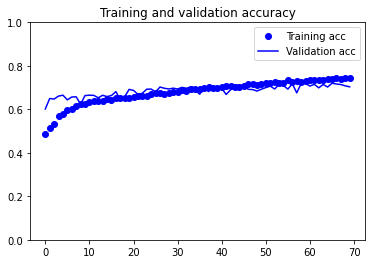

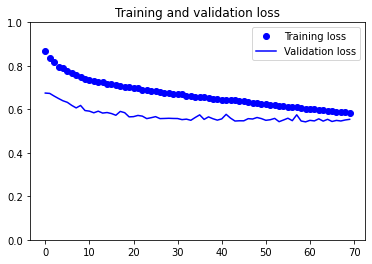

[0 1]
Normalized confusion matrix


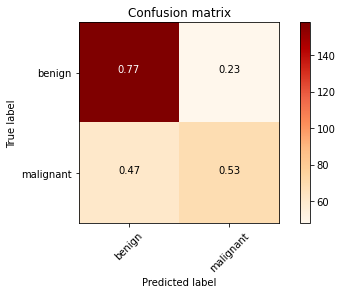

In [ ]:
from tensorflow.keras.applications import VGG16

tf.random.set_seed(7)

#import pretrained model
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

# Freeze layers
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# add fully connected layers as classifier
VGG16_FT = models.Sequential()
VGG16_FT.add(conv_base)
VGG16_FT.add(layers.Flatten())
VGG16_FT.add(layers.Dense(256, activation='relu'))
VGG16_FT.add(layers.Dropout(rate=.5))
VGG16_FT.add(layers.Dense(256, activation='relu'))
VGG16_FT.add(layers.Dropout(rate=.5))
VGG16_FT.add(layers.Dense(2, activation='sigmoid'))


VGG16_FT.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-6),
              metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)


history = VGG16_FT.fit(augmentedData, augmentedLabels, epochs=100, batch_size=32, callbacks=[earlyStopCallback], validation_split=0.2, class_weight = weights)


pred = VGG16_FT.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = VGG16_FT.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(VGG16_FT, testSet, testLabels, classes)


In [ ]:
VGG16_FT.save(os.path.join(projectPath + dir_name,"model1.h5")) 

print('done')

done


# **VGG16-Feature Extraction**

In [ ]:
from tensorflow.keras.applications import VGG16

tf.random.set_seed(7)

#import pretrained model
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()
conv_base.trainable = False

# add fully connected layers as classifier
VGG16_FE = models.Sequential()
VGG16_FE.add(conv_base)
VGG16_FE.add(layers.Flatten())
VGG16_FE.add(layers.Dense(256, activation='relu'))
VGG16_FE.add(layers.Dropout(rate=.5))
VGG16_FE.add(layers.Dense(256, activation='relu'))
VGG16_FE.add(layers.Dropout(rate=.5))
VGG16_FE.add(layers.Dense(2, activation='sigmoid'))


VGG16_FE.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

history = VGG16_FE.fit(augmentedData, augmentedLabels, epochs=100, batch_size=32, callbacks=[earlyStopCallback], validation_split=0.2, class_weight = weights)

pred = VGG16_FE.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = VGG16_FE.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(VGG16_FE, testSet, testLabels, classes)



In [ ]:
models = [VGG16_FT, VGG16_FE]

plotRocCurves(models, testSet, testLabels, ['VGG16_FineTuning', 'VGG16_FeatureExtraction'])

# **VGG19**

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.74      0.75      0.75       219
           1       0.52      0.51      0.52       117

    accuracy                           0.67       336
   macro avg       0.63      0.63      0.63       336
weighted avg       0.67      0.67      0.67       336

11/11 [==============================] - 1s 78ms/step - loss: 0.6144 - accuracy: 0.6667
0.6143831014633179 0.6666666865348816


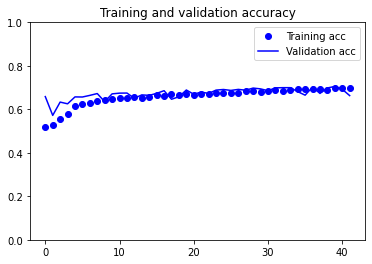

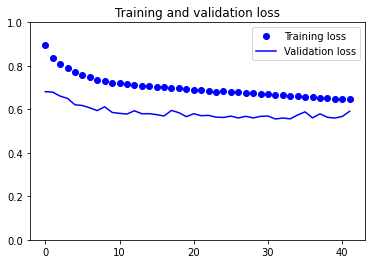

[0 1]
Normalized confusion matrix


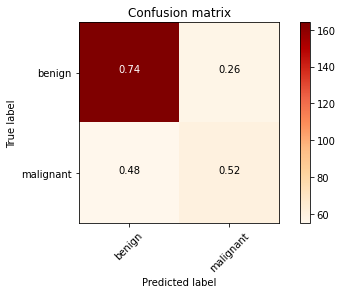

In [ ]:
from tensorflow.keras.applications import VGG19

tf.random.set_seed(7)

#import pretrained model
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

# Freeze layers
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
# add fully connected layers as classifier
VGG19_FT = models.Sequential()
VGG19_FT.add(conv_base)
VGG19_FT.add(layers.Flatten())
VGG19_FT.add(layers.Dense(256, activation='relu'))
VGG19_FT.add(layers.Dropout(rate=.5))
VGG19_FT.add(layers.Dense(256, activation='relu'))
VGG19_FT.add(layers.Dropout(rate=.5))
VGG19_FT.add(layers.Dense(2, activation='sigmoid'))


VGG19_FT.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-6),
              metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

history = VGG19_FT.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2, class_weight = weights)

pred = VGG19_FT.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = VGG19_FT.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(VGG19_FT, testSet, testLabels, classes)


In [ ]:
VGG19_FT.save(os.path.join(projectPath + dir_name,"model2.h5")) 

print('done')

done


# **VGG19-Feature Extraction**

In [ ]:
from tensorflow.keras.applications import VGG19

tf.random.set_seed(7)

#import pretrained model
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

# Freeze layers
conv_base.trainable = False
        
# add fully connected layers as classifier
VGG19_FE = models.Sequential()
VGG19_FE.add(conv_base)
VGG19_FE.add(layers.Flatten())
VGG19_FE.add(layers.Dense(256, activation='relu'))
VGG19_FE.add(layers.Dropout(rate=.5))
VGG19_FE.add(layers.Dense(256, activation='relu'))
VGG19_FE.add(layers.Dropout(rate=.5))
VGG19_FE.add(layers.Dense(2, activation='sigmoid'))


VGG19_FE.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-6),
              metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

history = VGG19_FE.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2, class_weight = weights)

pred = VGG19_FE.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = VGG19_FE.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(VGG19_FE, testSet, testLabels, classes)


In [ ]:
VGG19_FT.save(os.path.join(projectPath + dir_name,"model2.h5")) 

print('done')

done


# **ResNet50**

We test ResNet50 neural network trained on imagenet dataset, freezing different convolutional layer belonging to different blocks and appending different fully connected neural networks as classifier.

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/100
268/268 [==============================] - 32s 103ms/step - loss: 0.8544 - accuracy: 0.5581 - val_loss: 0.8213 - val_accuracy: 0.4115
Epoch 2/100
268/268 [==============================] - 26s 97ms/step - loss: 0.7786 - accuracy: 0.5993 - val_loss: 0.6230 - val_accuracy: 0.6534
Epoch 3/100
268/268 [==============================] - 26s 97ms/step - loss: 0.7637 - accuracy: 0.6167 - val_loss: 0.6118 - val_accuracy: 0.6539
Epoch 4/100
268/268 [==============================] - 26s 97ms/step - loss: 0.7465 - accuracy: 0.6333 - val_loss: 0.6575 - val_accuracy: 0.5684
Epoch 5/100
268/268 [==============================] - 26s 97ms/step - loss: 0.7404 - accuracy: 0.6232 - val_loss: 0.6021 - val_accuracy: 0.6418
Epoch 6/100
268/268 [==============================] - 26s 97ms/step - loss: 0.7437 - accuracy: 0.6233 - val_loss: 0.6801 - val_accuracy: 0.5586
Epoch 7/100
268/268 [==============================] - 26s 97ms/

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.85      0.15      0.26       219
           1       0.37      0.95      0.54       117

    accuracy                           0.43       336
   macro avg       0.61      0.55      0.40       336
weighted avg       0.68      0.43      0.35       336

11/11 [==============================] - 1s 51ms/step - loss: 0.9799 - accuracy: 0.4286
0.9798863530158997 0.4285714328289032


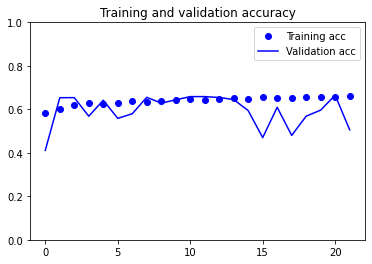

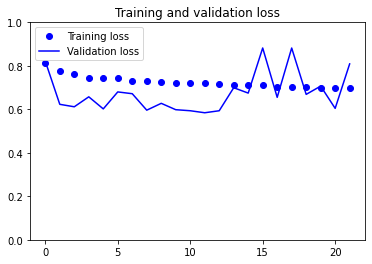

[0 1]
Normalized confusion matrix


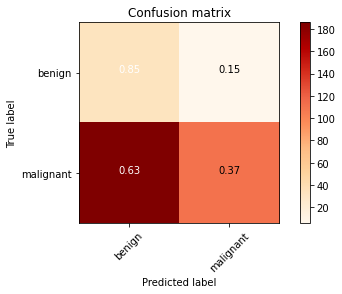

In [ ]:
from tensorflow.keras.applications import ResNet50

tf.random.set_seed(7)

# trick to riproduce 3 layer
img_input = tf.keras.layers.Input(shape=(150, 150, 1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    

# pre-trained network
conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

#'conv5_block3_1_conv'
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# classifier
ResNet50_FT = models.Sequential()
ResNet50_FT.add(conv_base)
ResNet50_FT.add(layers.Flatten())
ResNet50_FT.add(layers.Dense(256, activation='relu'))
ResNet50_FT.add(layers.Dropout(rate=.5))
ResNet50_FT.add(layers.Dense(2, activation='sigmoid'))

ResNet50_FT.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=2e-6),
                metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = ResNet50_FT.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2, class_weight = weights)

pred = ResNet50_FT.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = ResNet50_FT.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(ResNet50_FT, testSet, testLabels, classes)



# **ResNet50-Feature Extraction**

Epoch 1/100
268/268 [==============================] - 22s 73ms/step - loss: 0.9134 - accuracy: 0.5169 - val_loss: 0.6833 - val_accuracy: 0.5885
Epoch 2/100
268/268 [==============================] - 19s 70ms/step - loss: 0.8587 - accuracy: 0.4968 - val_loss: 0.7110 - val_accuracy: 0.4115
Epoch 3/100
268/268 [==============================] - 19s 70ms/step - loss: 0.8393 - accuracy: 0.4935 - val_loss: 0.6915 - val_accuracy: 0.5979
Epoch 4/100
268/268 [==============================] - 19s 69ms/step - loss: 0.8244 - accuracy: 0.5038 - val_loss: 0.6992 - val_accuracy: 0.4115
Epoch 5/100
268/268 [==============================] - 19s 70ms/step - loss: 0.8171 - accuracy: 0.5050 - val_loss: 0.6892 - val_accuracy: 0.5890
Epoch 6/100
268/268 [==============================] - 19s 70ms/step - loss: 0.8155 - accuracy: 0.5069 - val_loss: 0.6948 - val_accuracy: 0.4208
Epoch 7/100
268/268 [==============================] - 19s 70ms/step - loss: 0.8147 - accuracy: 0.4993 - val_loss: 0.6948 - val_ac

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.65      1.00      0.79       219
           1       0.67      0.02      0.03       117

    accuracy                           0.65       336
   macro avg       0.66      0.51      0.41       336
weighted avg       0.66      0.65      0.53       336

11/11 [==============================] - 1s 50ms/step - loss: 0.6869 - accuracy: 0.6548
0.6868984699249268 0.6547619104385376


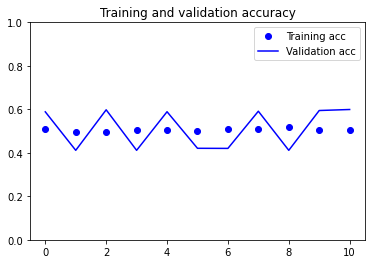

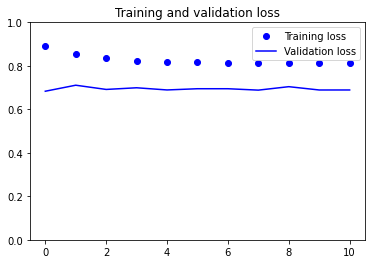

[0 1]
Normalized confusion matrix


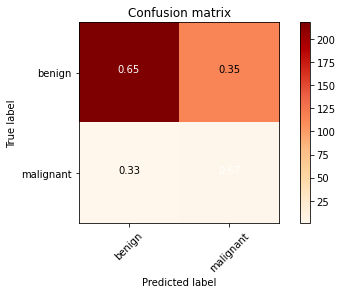

In [ ]:
from tensorflow.keras.applications import ResNet50

tf.random.set_seed(7)

# trick to riproduce 3 layer
img_input = tf.keras.layers.Input(shape=(150, 150, 1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    

# pre-trained network
conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


conv_base.trainable = False

# classifier
ResNet50_FE = models.Sequential()
ResNet50_FE.add(conv_base)
ResNet50_FE.add(layers.Flatten())
ResNet50_FE.add(layers.Dense(256, activation='relu'))
ResNet50_FE.add(layers.Dropout(rate=.5))
ResNet50_FE.add(layers.Dense(2, activation='sigmoid'))

ResNet50_FE.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=2e-6),
                metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = ResNet50_FE.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2, class_weight = weights)

pred = ResNet50_FE.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = ResNet50_FE.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(ResNet50_FE, testSet, testLabels, classes)


# **InceptionV3**

Epoch 1/100
268/268 [==============================] - 44s 129ms/step - loss: 0.8204 - accuracy: 0.5795 - val_loss: 0.6293 - val_accuracy: 0.6530
Epoch 2/100
268/268 [==============================] - 33s 124ms/step - loss: 0.6771 - accuracy: 0.6978 - val_loss: 0.6289 - val_accuracy: 0.6427
Epoch 3/100
268/268 [==============================] - 33s 123ms/step - loss: 0.5842 - accuracy: 0.7471 - val_loss: 0.6385 - val_accuracy: 0.7076
Epoch 4/100
268/268 [==============================] - 33s 124ms/step - loss: 0.4624 - accuracy: 0.8156 - val_loss: 0.7787 - val_accuracy: 0.6726
Epoch 5/100
268/268 [==============================] - 33s 123ms/step - loss: 0.3807 - accuracy: 0.8489 - val_loss: 0.8796 - val_accuracy: 0.6852
Epoch 6/100
268/268 [==============================] - 33s 124ms/step - loss: 0.3066 - accuracy: 0.8891 - val_loss: 1.1234 - val_accuracy: 0.6899
Epoch 7/100
268/268 [==============================] - 33s 124ms/step - loss: 0.2285 - accuracy: 0.9179 - val_loss: 1.2206 -

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.75      0.78      0.76       219
           1       0.55      0.50      0.53       117

    accuracy                           0.68       336
   macro avg       0.65      0.64      0.65       336
weighted avg       0.68      0.68      0.68       336

11/11 [==============================] - 0s 31ms/step - loss: 2.3574 - accuracy: 0.6845
2.357365846633911 0.6845238208770752


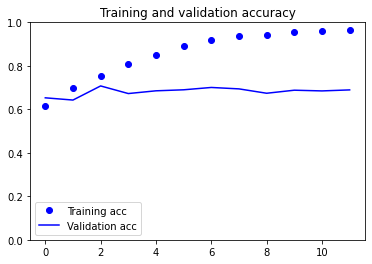

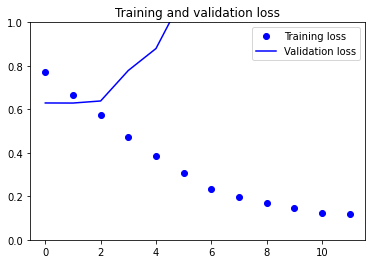

[0 1]
Normalized confusion matrix


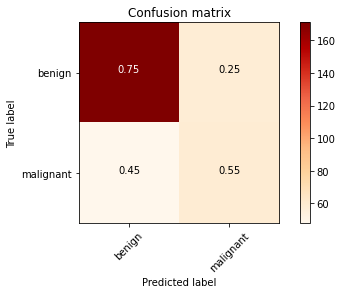

In [ ]:
from tensorflow.keras.applications import InceptionV3

tf.random.set_seed(7)

# trick to riproduce 3 layer
img_input = tf.keras.layers.Input(shape=(150, 150, 1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    

# pre-trained network
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

set_trainable = False

for layer in conv_base.layers[:249]:
   layer.trainable = False
for layer in conv_base.layers[249:]:
   layer.trainable = True

# classifier
InceptionV3_FT = models.Sequential()
InceptionV3_FT.add(conv_base)
InceptionV3_FT.add(layers.Flatten())
InceptionV3_FT.add(layers.Dense(256, activation='relu'))
InceptionV3_FT.add(layers.Dropout(rate=.5))
InceptionV3_FT.add(layers.Dense(2, activation='sigmoid'))

conv_base.trainable = True


InceptionV3_FT.compile(loss='binary_crossentropy',
      optimizer=optimizers.RMSprop(lr=2e-6),
      metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


history = InceptionV3_FT.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2, class_weight = weights)

pred = InceptionV3_FT.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = InceptionV3_FT.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(InceptionV3_FT, testSet, testLabels, classes)


# **InceptionV3-Feature Extraction**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 514       
Total params: 26,522,146
Trainable params: 4,719,362
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/100
268/268 [==============================] - 16s 47ms/step - loss: 0.8240 - accuracy: 0.50

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.83      0.68      0.75       219
           1       0.55      0.74      0.64       117

    accuracy                           0.70       336
   macro avg       0.69      0.71      0.69       336
weighted avg       0.74      0.70      0.71       336

11/11 [==============================] - 0s 30ms/step - loss: 0.5773 - accuracy: 0.7024
0.5772879719734192 0.7023809552192688


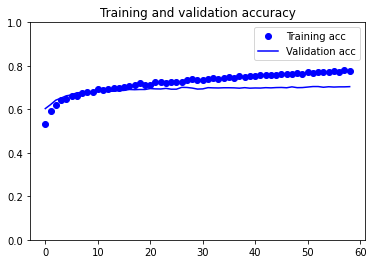

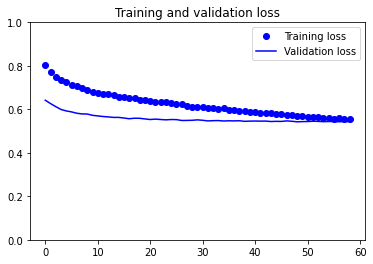

[0 1]
Normalized confusion matrix


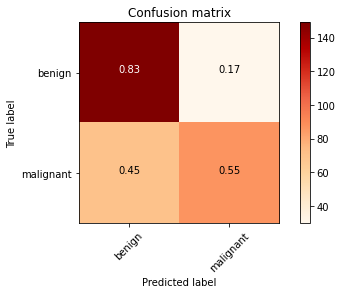

In [ ]:
from tensorflow.keras.applications import InceptionV3

tf.random.set_seed(7) 

# pre-trained network
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


# classifier
InceptionV3_FE = models.Sequential()
InceptionV3_FE.add(conv_base)
InceptionV3_FE.add(layers.Flatten())
InceptionV3_FE.add(layers.Dense(256, activation='relu'))
InceptionV3_FE.add(layers.Dropout(rate=.5))
InceptionV3_FE.add(layers.Dense(2, activation='sigmoid'))

conv_base.trainable = False

InceptionV3_FE.summary()

InceptionV3_FE.compile(loss='binary_crossentropy',
      optimizer=optimizers.RMSprop(lr=2e-6),
      metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


history = InceptionV3_FE.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2, class_weight = weights)

pred = InceptionV3_FE.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = InceptionV3_FE.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(InceptionV3_FE, testSet, testLabels, classes)


In [ ]:
InceptionV3_FE.save(os.path.join(projectPath + dir_name,"model3.h5")) 

print('done')

done


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 202

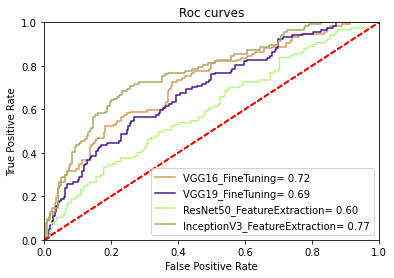

In [ ]:
models = [VGG16_FT, VGG19_FT, ResNet50_FE, InceptionV3_FE]

plotRocCurves(models, testSet, testLabels, ['VGG16_FineTuning', 'VGG19_FineTuning', 'ResNet50_FeatureExtraction', 'InceptionV3_FeatureExtraction'])